In [1161]:
from display_utils import getHeader

<div style="font-size: 30px"><b>Data Sources</b></div>

<b>1.</b> This project uses the Global Landslide Catalog dataset exported from the NASA's Open Data Portal https://data.nasa.gov/Earth-Science/Global-Landslide-Catalog-Export/dd9e-wu2v/about_data

As required by the host page, we cite the following two sources

<i>Kirschbaum, D. B., Adler, R., Hong, Y., Hill, S., & Lerner-Lam, A. (2010). A global landslide catalog for hazard applications: method, results, and limitations. Natural Hazards, 52(3), 561–575. doi:10.1007/s11069-009-9401-4. [1]</i>

<i>Kirschbaum, D.B., T. Stanley, Y. Zhou (In press, 2015). Spatial and Temporal Analysis of a Global Landslide Catalog. Geomorphology. doi:10.1016/j.geomorph.2015.03.016. [2]</i>

<b>2.</b> We will also use the GDP by country dataset obtained from https://github.com/datasets/gdp/blob/master/data/gdp.csv.


<div style="font-size: 30px"><b>Project Objectives</b></div>

<div style="font-size: 20px">We would like to understand the relationship between <b>casualties</b> (as defined below) and other variables from the datesets such as event time and country GDP in landslide events. We will use explorative data analysis and build interpretable regression models toward this goal.</div> 

<div style="border: 1px solid lightgrey; width: 90%"></div>

<div style="font-size: 30px"><b>Explorative Data Analysis</b></div>

In [1162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [1163]:
landslide_data = pd.read_csv('landslide_data.csv')

In [1164]:
landslide_data.shape

(11033, 31)

<div style="font-size: 25px"><b>Data Cleaning and Formatting</b></div>

<div style="font-size: 20px"><b>Global Landslide Dataset</b></div>
We will start with the global landslide dataset

<div style="border: 1px solid lightgrey; width: 80%"></div>

<div style="font-size: 15px"><b>Convert event_date to pd.datetime</b></div>

In [1165]:
landslide_data['timestamp'] = pd.to_datetime(landslide_data['event_date'], format='%m/%d/%Y %H:%M:%S %p')

In [1166]:
landslide_data['hour'] = landslide_data['timestamp'].dt.hour

In [1167]:
landslide_data['year'] = landslide_data['timestamp'].dt.year

In [1168]:
landslide_data['month'] = landslide_data['timestamp'].dt.month

This contains the event time. We will drop other columns that contain this information.

In [1169]:
landslide_data = landslide_data.drop(['event_date', 'event_time'], axis=1)

In [1170]:
landslide_data.shape

(11033, 33)

In [1171]:
landslide_data.columns

Index(['source_name', 'source_link', 'event_id', 'event_title',
       'event_description', 'location_description', 'location_accuracy',
       'landslide_category', 'landslide_trigger', 'landslide_size',
       'landslide_setting', 'fatality_count', 'injury_count', 'storm_name',
       'photo_link', 'notes', 'event_import_source', 'event_import_id',
       'country_name', 'country_code', 'admin_division_name',
       'admin_division_population', 'gazeteer_closest_point',
       'gazeteer_distance', 'submitted_date', 'created_date',
       'last_edited_date', 'longitude', 'latitude', 'timestamp', 'hour',
       'year', 'month'],
      dtype='object')

<div style="font-size: 15px"><b>Add event_source column</b></div>

In [1172]:
landslide_data['source_name'].nunique()

3918

In [1173]:
source_name_count_df = landslide_data.groupby(['source_name']).size().sort_values(ascending=False).reset_index(name="count")
source_name_count_df.head(10)

,source_name,count
0,Oregon DOT,768
1,maps.google.com,104
2,thehimalayantimes,75
3,news.xinhuanet,74
4,newsinfo.inquirer,71
5,thejakartapost,59
6,ibnlive.in,57
7,Times of India,47
8,The Jakarta Post,46
9,The Himalayan Times,43


We will take only the 10 source_name's and create a new group 'others' for the rest

In [1174]:
major_sources = set(source_name_count_df['source_name'].iloc[:10])

In [1175]:
def getEventSource(row):
    source = 'Others'
    if row['source_name'] in major_sources:
        source = row['source_name']
    row['event_source'] = source
    return row
landslide_data = landslide_data.apply(getEventSource, axis=1)

In [1176]:
landslide_data['event_source'] = landslide_data['event_source'].astype('category')

In [1177]:
landslide_data[landslide_data['source_name'] == 'maps.google.com'].head(2)

,source_name,source_link,event_id,event_title,event_description,location_description,location_accuracy,landslide_category,landslide_trigger,landslide_size,...,submitted_date,created_date,last_edited_date,longitude,latitude,timestamp,hour,year,month,event_source
495,maps.google.com,http://maps.google.com.br/maps/ms?source=embed...,1680,"Rua Ceará, bairro Quitandinha",Rua Ceará - bairro Quitandinha Deslizamento c...,"Rua Ceará, bairro Quitandinha",exact,landslide,downpour,medium,...,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-43.2212,-22.5232,2010-04-06 12:00:00,12,2010,4,maps.google.com
517,maps.google.com,http://maps.google.com.br/maps/ms?source=embed...,1633,Morro da Mangueira,O mapa da devastação no Rio. Queda de barreir...,Morro da Mangueira,1km,mudslide,downpour,medium,...,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-43.2394,-22.9033,2010-04-06 12:00:00,12,2010,4,maps.google.com


We will drop source_name and source_link. The information from these two columns are represented in event_source.

In [1178]:
landslide_data = landslide_data.drop(['source_name', 'source_link'], axis=1)


In [1179]:
landslide_data.shape

(11033, 32)

<div style="font-size: 15px"><b>Landslide description with categorical variables</b> <span>(contain missing values. We will deal with them separately, see details below)</span></div>

We will convert a few variables that classify the landslide events in groups into categorical variables

In [1180]:
landslide_info_categoricals = ['landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting']

<b>Missing values</b>
<div>We will delete rows with missing values for landslide_category and landslide_size. For landslide_trigger, we will create a new group 'unknown' for the missing values. For landslide_setting, since there is already a class "unknown", we assign this value to the rows with missing landslide_setting.</div>

In [1181]:
landslide_data[['landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting']].isna().sum()

landslide_category     1
landslide_trigger     23
landslide_size         9
landslide_setting     69
dtype: int64

In [1182]:
landslide_data = landslide_data.dropna(subset = ['landslide_category'])

In [1183]:
landslide_data = landslide_data.dropna(subset = ['landslide_size'])

In [1184]:
landslide_data.loc[landslide_data['landslide_trigger'].isna(), 'landslide_trigger'] = 'unknown'

In [1185]:
landslide_data.loc[landslide_data['landslide_setting'].isna(), 'landslide_setting'] = 'unknown'

In [1186]:
landslide_data[['landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting']].isna().sum()

landslide_category    0
landslide_trigger     0
landslide_size        0
landslide_setting     0
dtype: int64

In [1187]:
for column in landslide_info_categoricals:
    landslide_data[column] = landslide_data[column].astype('category')

<div style="font-size: 15px"><b>fatality_count</b></div>

In [1188]:
landslide_data[['fatality_count']].isna().sum()

fatality_count    1383
dtype: int64

In [1189]:
landslide_data = landslide_data.dropna(subset = ['fatality_count'])

landslide_data['fatality_count'].describe()

<Axes: xlabel='fatality_count', ylabel='Density'>

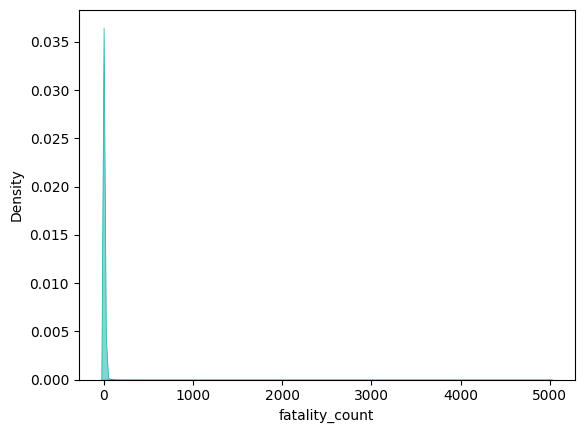

In [1190]:
fig, ax = plt.subplots()
sns.kdeplot(landslide_data['fatality_count'], ax=ax, fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')

<b>There are outliers to the right having extremely big values. This skews the distribution. The values seem to be correct and we will keep the outliers as they may represent underlying structures in the true distribution. </b>

In [1191]:
landslide_data[landslide_data['fatality_count'] > 1000].size

96

In [1192]:
landslide_data_without_outliers = landslide_data[np.abs(landslide_data["fatality_count"]-landslide_data["fatality_count"].mean())<=(3*landslide_data["fatality_count"].std())] 

In [1193]:
landslide_data['log_fatality_count'] = np.log2(landslide_data['fatality_count'] + 1)

In [1194]:
landslide_data.columns

Index(['event_id', 'event_title', 'event_description', 'location_description',
       'location_accuracy', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count',
       'storm_name', 'photo_link', 'notes', 'event_import_source',
       'event_import_id', 'country_name', 'country_code',
       'admin_division_name', 'admin_division_population',
       'gazeteer_closest_point', 'gazeteer_distance', 'submitted_date',
       'created_date', 'last_edited_date', 'longitude', 'latitude',
       'timestamp', 'hour', 'year', 'month', 'event_source',
       'log_fatality_count'],
      dtype='object')

In [1195]:
landslide_data_without_outliers['log_fatality_count'] = np.log2(landslide_data['fatality_count'] + 1)

/var/folders/65/_pqxxk_n1sl_p8w5kyxhrm640000gp/T/ipykernel_56371/1082021034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landslide_data_without_outliers['log_fatality_count'] = np.log2(landslide_data['fatality_count'] + 1)


<Axes: xlabel='log_fatality_count', ylabel='Density'>

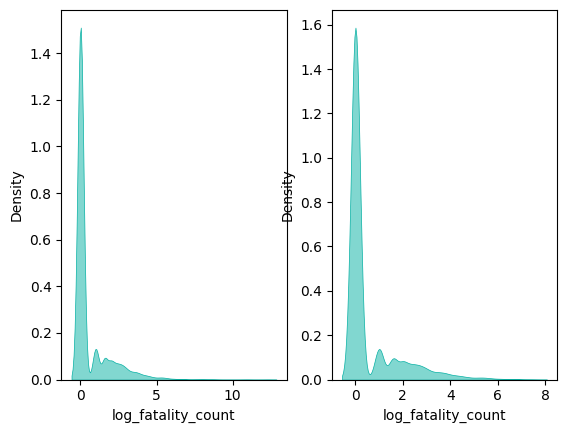

In [1196]:
fig, axes = plt.subplots(ncols=2, nrows=1)
sns.kdeplot(landslide_data['log_fatality_count'], ax=axes[0], fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')
sns.kdeplot(landslide_data_without_outliers['log_fatality_count'], ax=axes[1], fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')

In [1197]:
landslide_data.shape
# landslide_data_without_outliers['log_fatality_count'] = np.log2(landslide_data['fatality_count'] + 1)

(9640, 33)

In [1198]:
# fig, ax = plt.subplots()
# sns.kdeplot(landslide_data_without_outliers['log_fatality_count'], ax=ax, fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')

<div style="font-size: 15px"><b>Select Columns to Use</b></div>
We will select columns that seem correlated with the target fatality_count

<b>A note for the choice of country_name over country_code: we will be joining the gdp data with the landslide data. It seems that the country code in the two tables are computed according to different conventions and they don't match for most countries. On the other handm, country name is consistent between the two tables.</b>

In [1199]:
used_columns = ['year', 'hour', 'month', 'event_source', 'landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting', 'fatality_count', 'log_fatality_count', 'injury_count', 'country_name', 'longitude', 'latitude']

In [1200]:
landslide_data = landslide_data[used_columns]

In [1201]:
landslide_data.shape

(9640, 14)

<div style="font-size: 15px"><b>Missing Values</b></div>
We have dealt some missing values above. In this section, we will look at other columns that contain missing values.

In [1202]:
landslide_data.isna().sum()

year                     0
hour                     0
month                    0
event_source             0
landslide_category       0
landslide_trigger        0
landslide_size           0
landslide_setting        0
fatality_count           0
log_fatality_count       0
injury_count          4297
country_name          1508
longitude                0
latitude                 0
dtype: int64

<div style="font-size: 12px"><b>1. injury_count missing values - Impute overall average</b></div>

In [1203]:
landslide_data['injury_count'] = landslide_data['injury_count'].fillna(landslide_data['injury_count'].mean())

<div style="font-size: 12px"><b>2. landslide_size missing values - Impute class average</b></div>
Since landslide_size is an ordinal categorical variable, we will convert it to numeric. When we do this, the class unknown is equivalent to a missing value. To fill these values, we will make use of the correlation between landslid_size and injury_count. Specifically, we will take the input points that have landslide_size not equal to unknown and compute the average injury_count for each class. Then for the rows with unknown landslide_size, we will find the class whose average is closest to its injury_count and assign it that class.

In [1204]:
injury_count_avg = landslide_data.groupby('landslide_size')['injury_count'].mean()

/var/folders/65/_pqxxk_n1sl_p8w5kyxhrm640000gp/T/ipykernel_56371/3384717988.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  injury_count_avg = landslide_data.groupby('landslide_size')['injury_count'].mean()


In [1205]:
injury_count_avg_dict = injury_count_avg.to_dict()

In [1206]:
del injury_count_avg_dict['unknown']
injury_count_avg_to_size = {avg: c for c, avg in injury_count_avg_dict.items()}
sorted_avg = sorted(injury_count_avg_to_size.keys())
injury_count_avg_to_size

{114.66666666666667: 'catastrophic',
 2.4496308319486064: 'large',
 0.7327190823186595: 'medium',
 0.34650302402020905: 'small',
 3.624024837335271: 'very_large'}

In [1207]:
import bisect
def find_size_lass(injury_count):
    closest_ind = bisect.bisect_left(sorted_avg, injury_count)
    size_class = injury_count_avg_to_size[sorted_avg[closest_ind]]
    return size_class
    

In [1208]:
index = (landslide_data['landslide_size'] == 'large') | (landslide_data['landslide_size'] == 'catastrophic')
landslide_data[index].head()

,year,hour,month,event_source,landslide_category,landslide_trigger,landslide_size,landslide_setting,fatality_count,log_fatality_count,injury_count,country_name,longitude,latitude
0,2008,12,8,Others,landslide,rain,large,mine,11.0,3.584963,0.750702,China,107.450000,32.562500
2,2007,12,1,Others,landslide,downpour,large,unknown,10.0,3.459432,0.750702,Peru,-75.358700,-11.129500
46,2009,12,7,Others,landslide,monsoon,large,unknown,13.0,3.807355,0.750702,Nepal,85.710000,28.000000
56,2010,12,1,Others,mudslide,downpour,large,unknown,22.0,4.523562,28.000000,Brazil,-44.322498,-23.013744
93,2016,6,9,Others,landslide,rain,large,unknown,0.0,0.000000,0.000000,NaN,94.514651,26.324724


In [1209]:
def get_landslide_size(row):
    size = row['landslide_size']
    if size == 'unknown':
        size = find_size_lass(row['injury_count'])
    injury_avg = injury_count_avg_dict[size]
    row['landslide_size'] = sorted_avg.index(injury_avg)
    return row        

In [1210]:
landslide_data = landslide_data.apply(get_landslide_size, axis=1)
landslide_data[landslide_data['landslide_size'] == 'unknown'].shape

(0, 14)

<div style="font-size: 12px"><b>3. country_code missing values - create new class unknown</b></div>
For missing country_code values, we will create a new class unknown.

In [1211]:
def assign_missing_country_code(row):
    if pd.isna(row['country_name']):
        row['country_name'] = 'unknown'
    return row
landslide_data = landslide_data.apply(assign_missing_country_code, axis=1)

<div style="font-size: 20px"><b>Country GDP Dataset</b></div>
We will now turn to the country GDP dataset

<div style="border: 1px solid lightgrey; width: 80%"></div>

In [1212]:
gdp_data = pd.read_csv('gdp_country.csv')

In [1213]:
gdp_data = pd.melt(gdp_data, id_vars=['Country Name'], value_vars=['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023'])

In [1214]:
gdp_data = gdp_data.rename(columns={'Country Name': 'country_name', 'variable': 'year'})

In [1215]:
gdp_data['year'] = pd.to_numeric(gdp_data['year'])

In [1216]:
landslide_data = landslide_data.merge(gdp_data, on=['country_name', 'year'], how='left' )

In [1217]:
landslide_data = landslide_data.rename(columns={'value': 'gdp'})

In [1218]:
landslide_data['gdp'].isna().sum()

np.int64(1837)

<b>We will fill the missing GDP with the mean.</b>

In [1219]:
landslide_data['gdp'] = landslide_data['gdp'].fillna(landslide_data['gdp'].mean())

In [1220]:
landslide_data['gdp'].isna().sum()

np.int64(0)

<div style="font-size: 20px"><b>Final Data and Variables Selection</b></div>

<div style="border: 1px solid lightgrey; width: 80%"></div>

In [1221]:
full_data = landslide_data

In [1222]:
full_data.columns

Index(['year', 'hour', 'month', 'event_source', 'landslide_category',
       'landslide_trigger', 'landslide_size', 'landslide_setting',
       'fatality_count', 'log_fatality_count', 'injury_count', 'country_name',
       'longitude', 'latitude', 'gdp'],
      dtype='object')

In [1223]:
full_data = full_data.drop(['fatality_count', 'country_name'], axis=1)

In [1224]:
full_data.columns

Index(['year', 'hour', 'month', 'event_source', 'landslide_category',
       'landslide_trigger', 'landslide_size', 'landslide_setting',
       'log_fatality_count', 'injury_count', 'longitude', 'latitude', 'gdp'],
      dtype='object')

<div style="width: 80%"></div>

<div style="font-size: 25px"><b>Data Visualization</b></div>

<div style="font-size: 20px"><b>Numeric Variables Distributions</b></div> 

<div style="border: 1px solid lightgrey; width: 80%"></div>

In [1225]:
numeric_columns = ['injury_count', 'longitude', 'latitude', 'gdp']

In [1226]:
def get_dist_numeric(col, full_data):
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    sns.kdeplot(full_data[col], ax=axes[0], fill=True, alpha=0.5, linewidth=0.5, color='#4D9DFF')
    sns.regplot(x=col, y="log_fatality_count", data=full_data,ax=axes[1], line_kws=dict(color='y'))
    axes[0].set_title('distribution')
    axes[1].set_title('relationship with log_fatality_count')

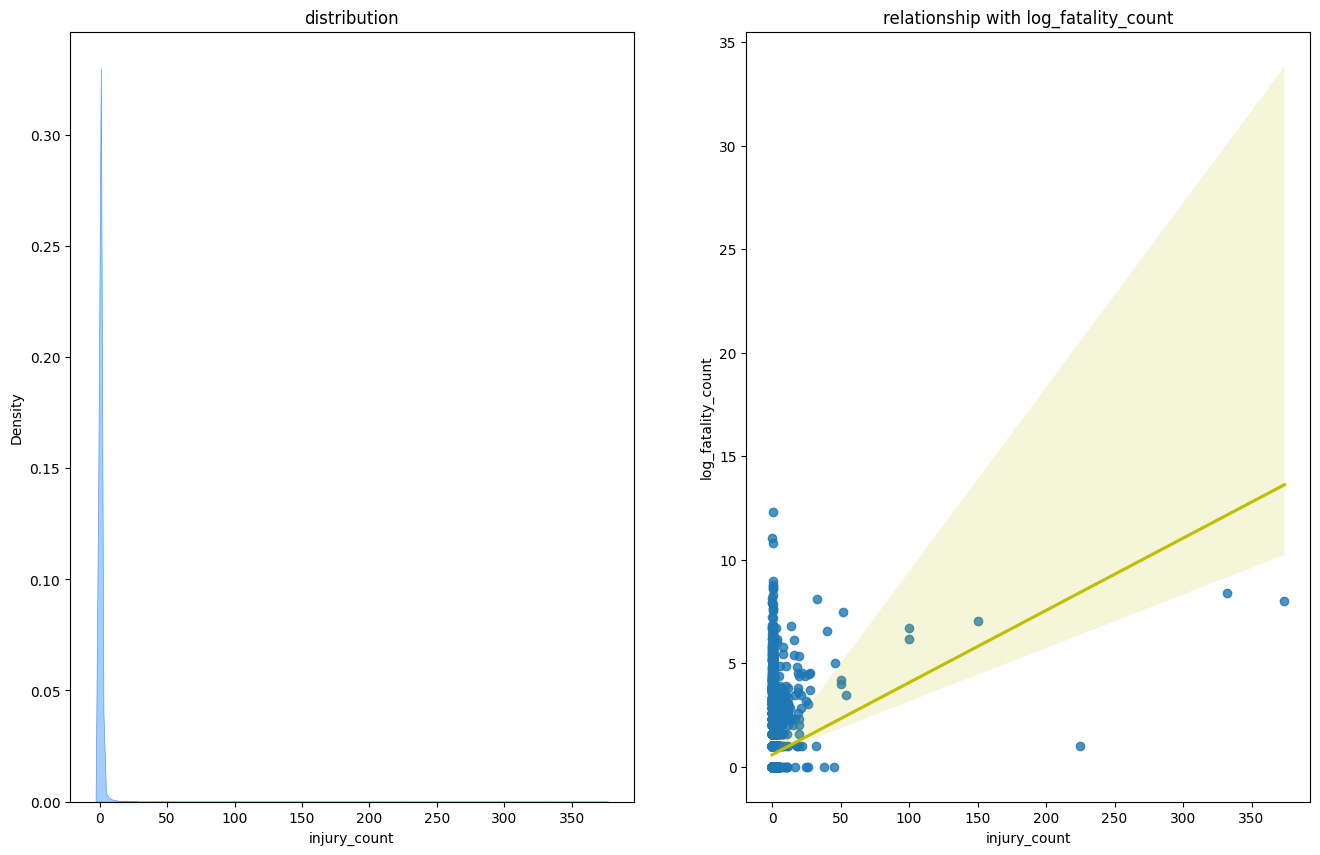

In [1227]:
get_dist_numeric('injury_count', full_data)

As with fatality_count, injury_count is right skewed with large values that have low counts. The relationship in the second graph is counter intuitive. Namely, there is as strong a correlation between injury and fatality count.

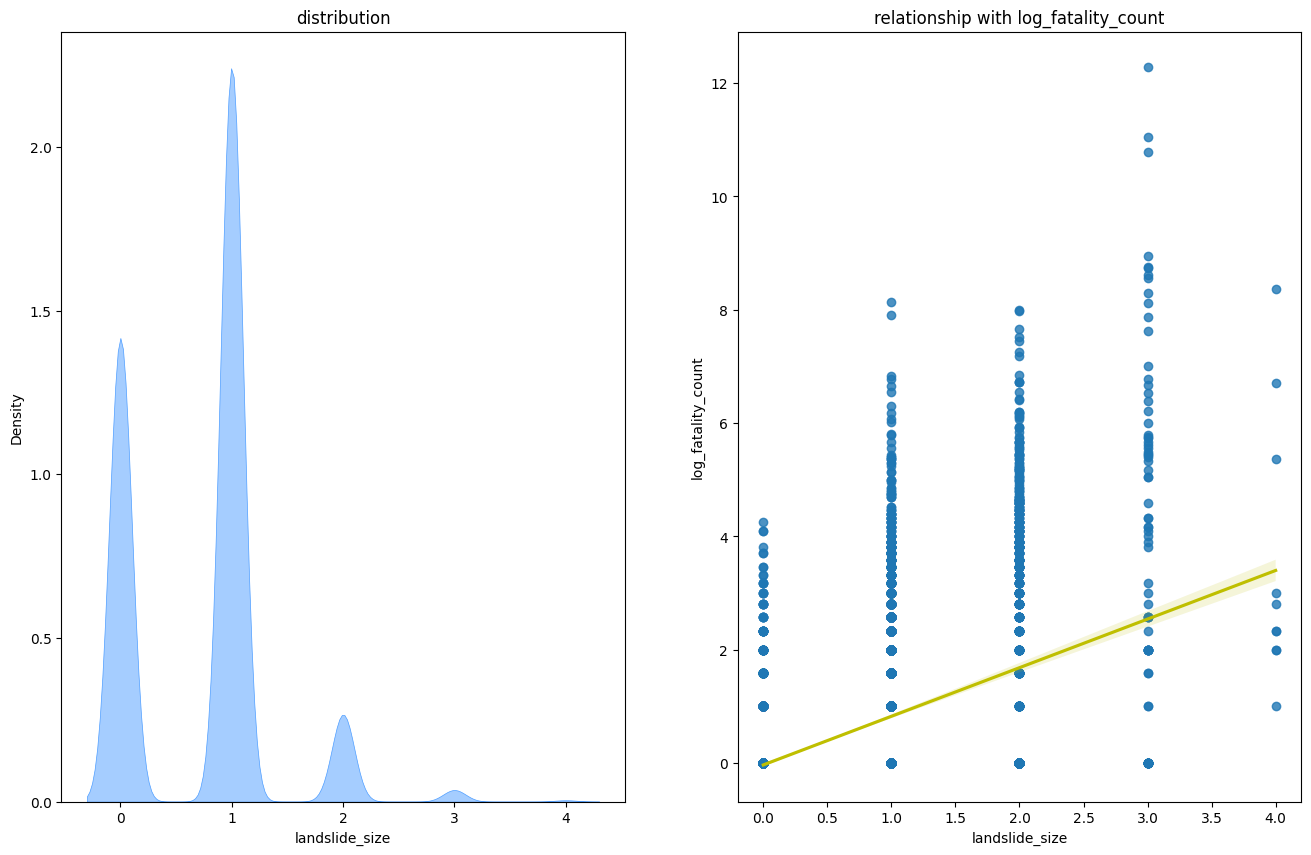

In [1228]:
get_dist_numeric('landslide_size', full_data)

Possibly due to the outliers with high fatality_count and landslide_size = 4, fatality_count and landslide_size have a clear positive correlation

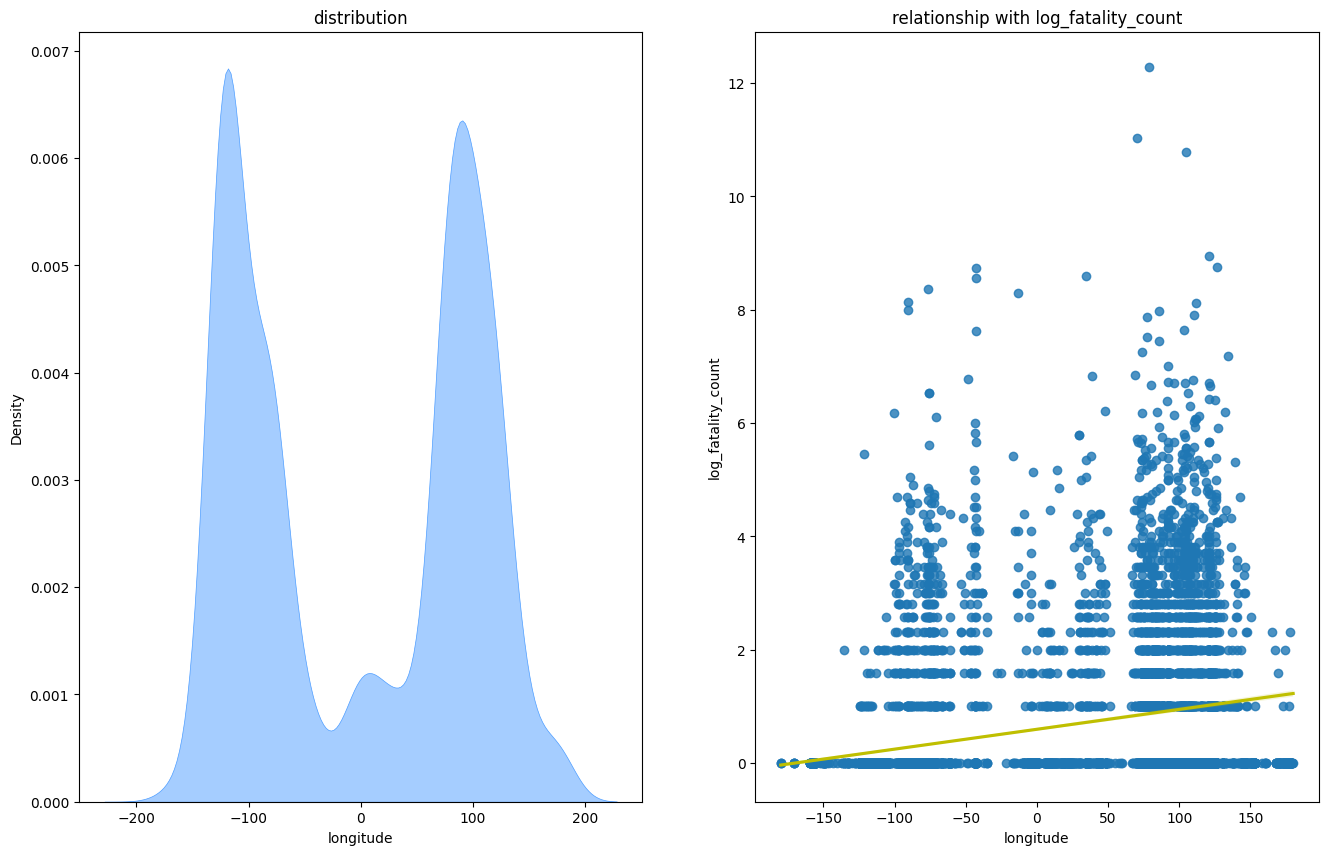

In [1229]:
get_dist_numeric('longitude', full_data)

longitude does not seem to be very informative.

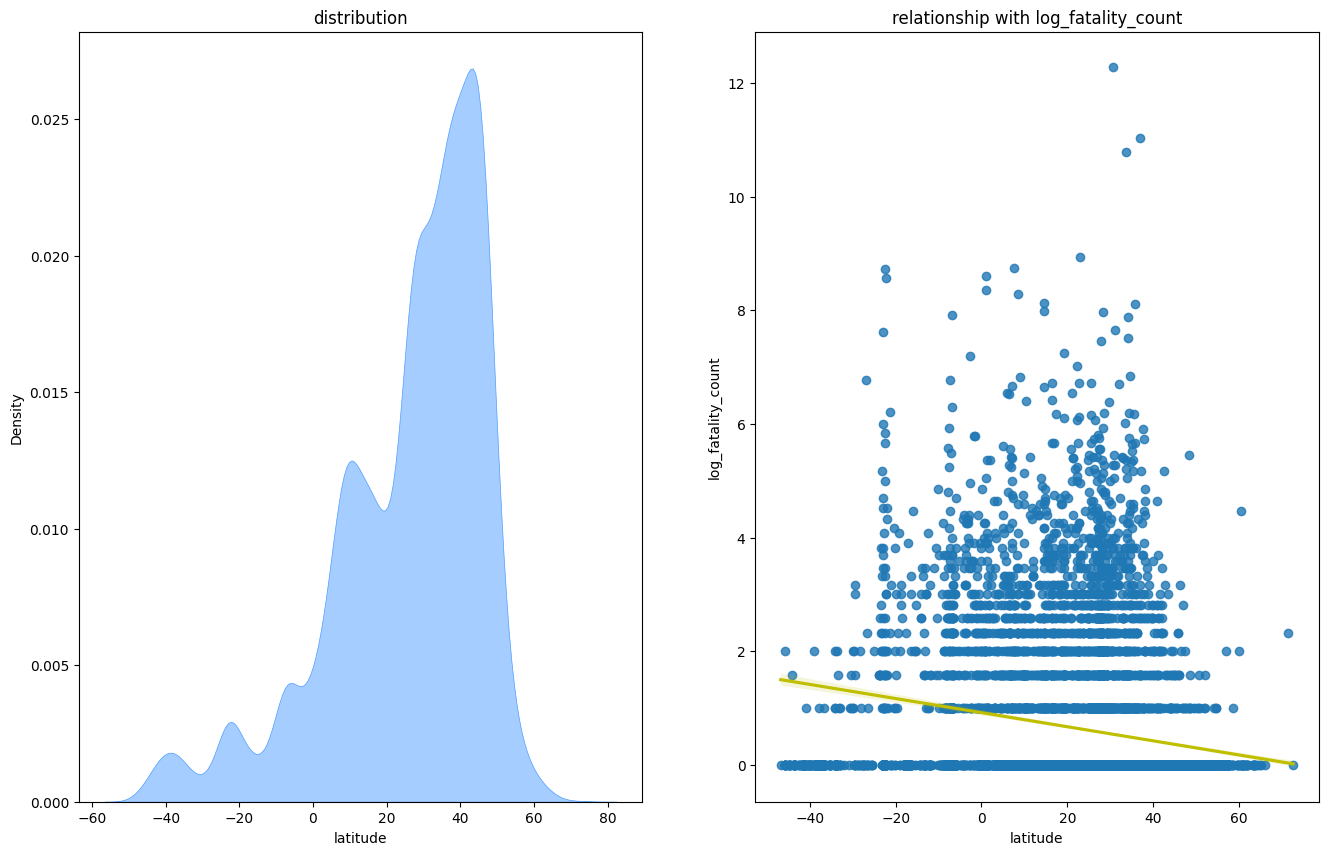

In [1230]:
get_dist_numeric('latitude', full_data)

latitude does not seem to be very informative.

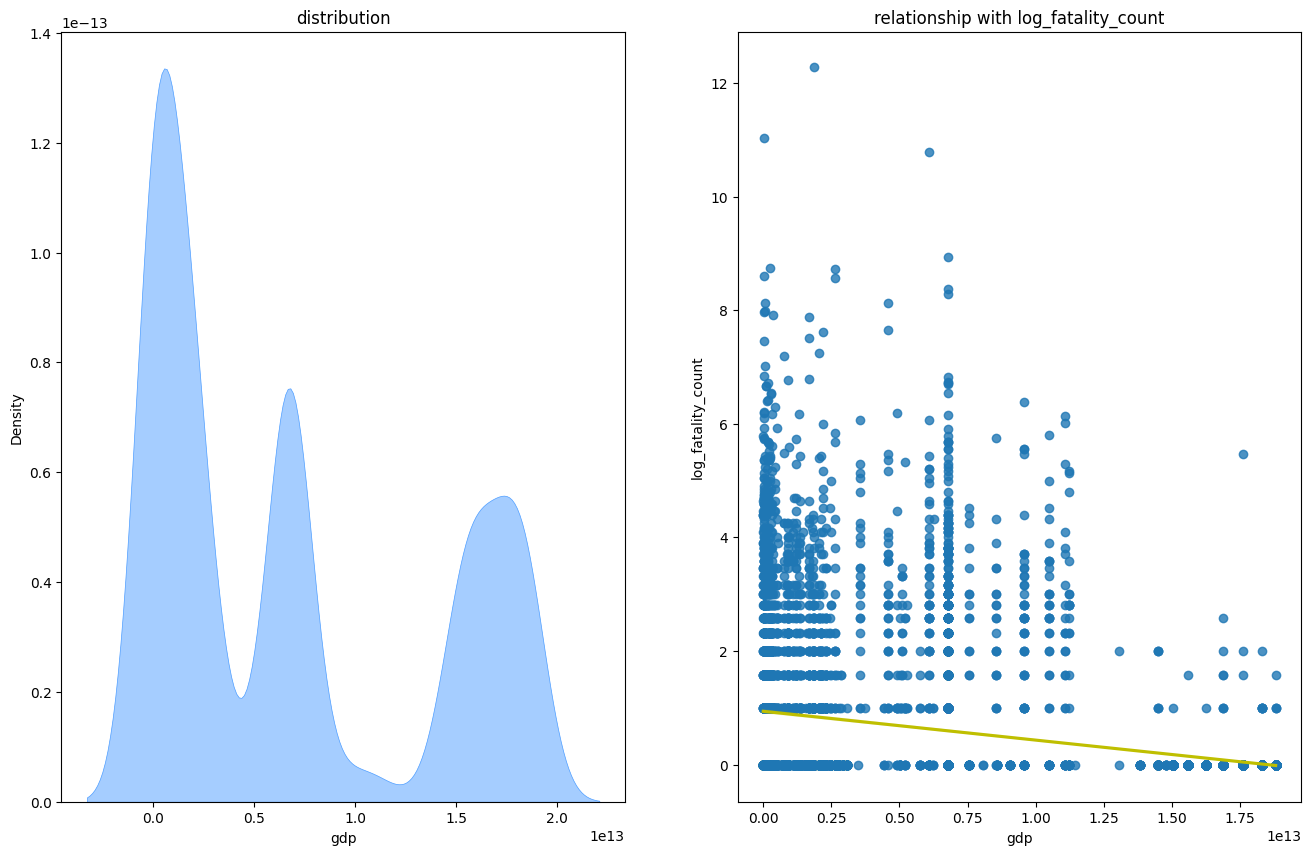

In [1231]:
get_dist_numeric('gdp', full_data)

The relationship between fatality and the GDP of the country where the event occurred shown in the second graph is intuitive. A higher GDP indicates a more developed state which means a better safty and medical measures to reduce casualty.  

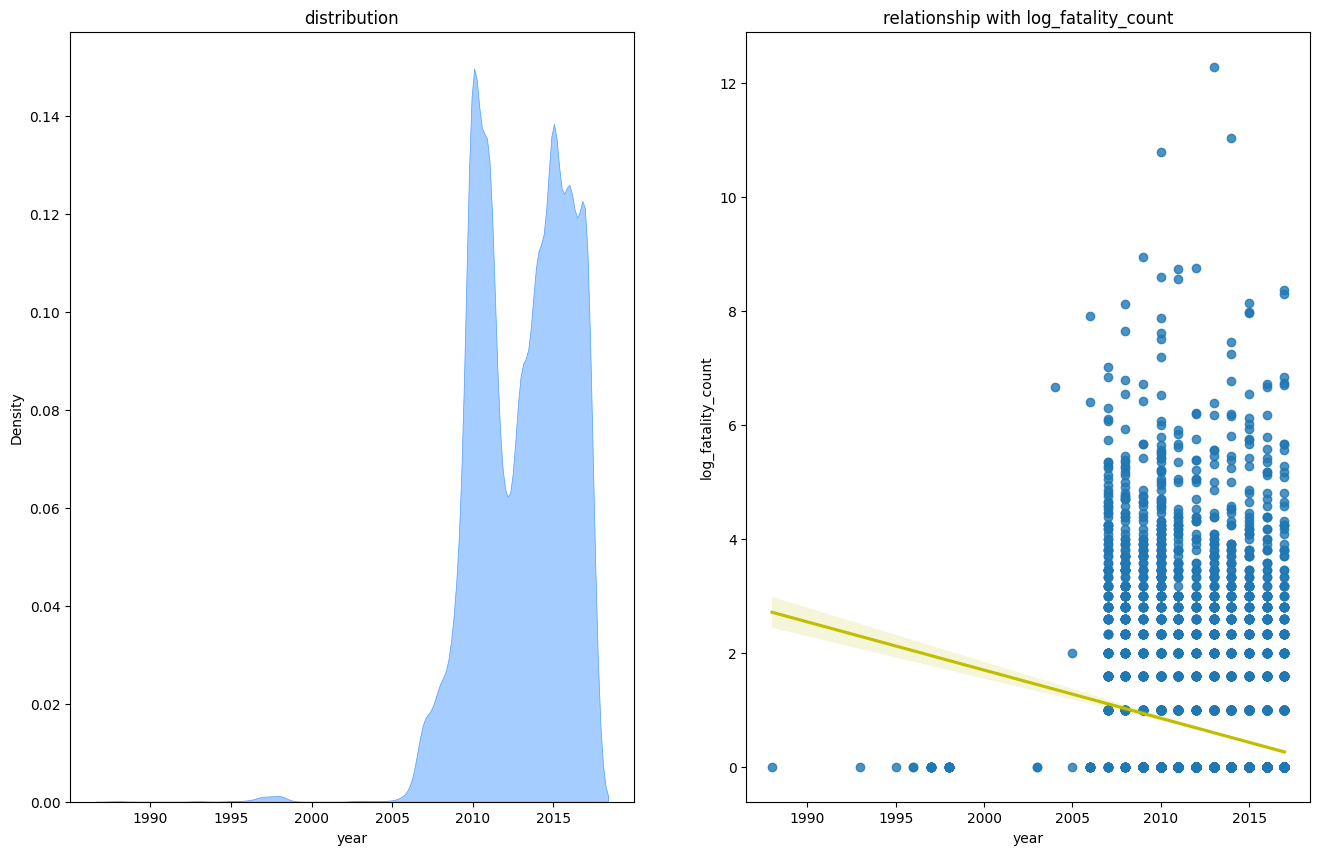

In [1232]:
get_dist_numeric('year', full_data)

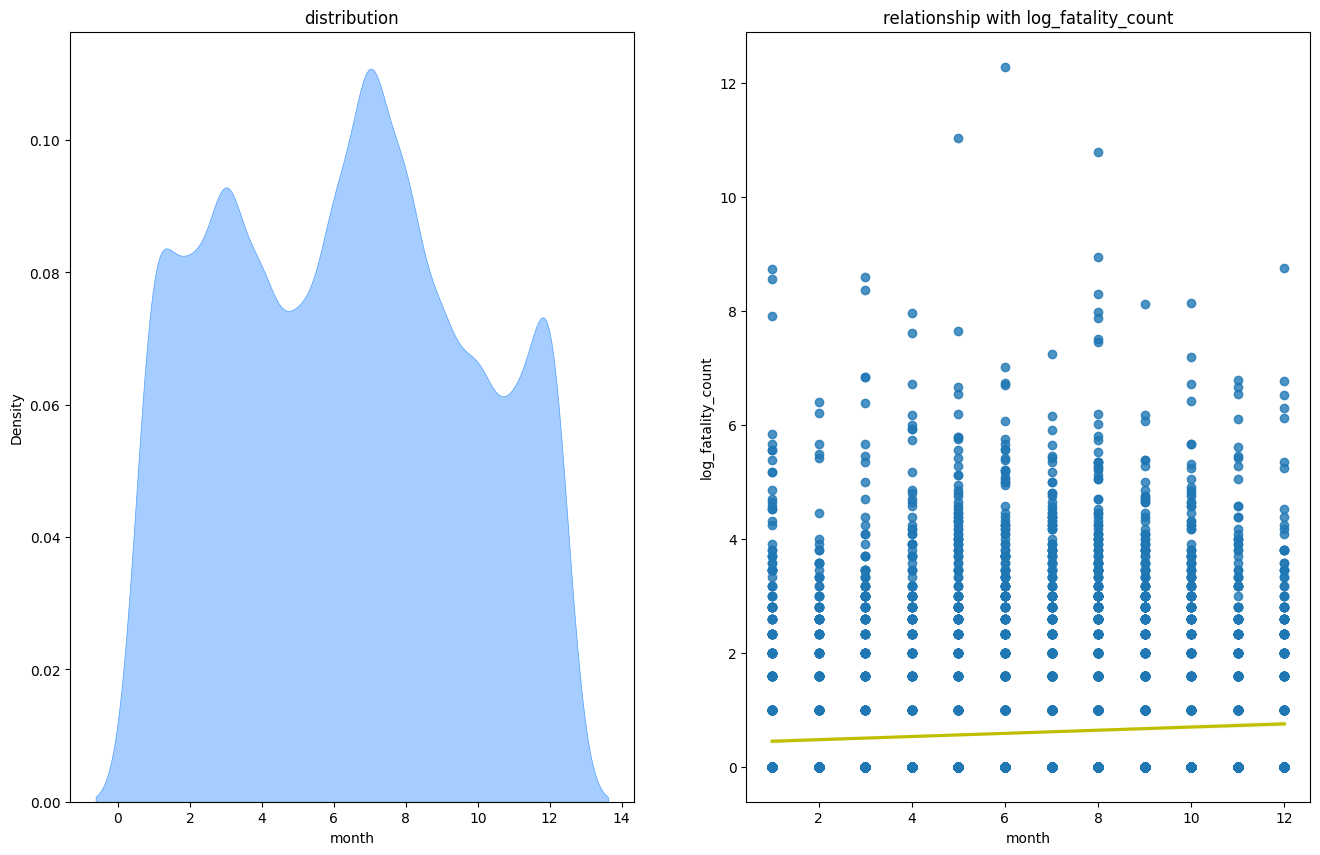

In [1233]:
get_dist_numeric('month', full_data)

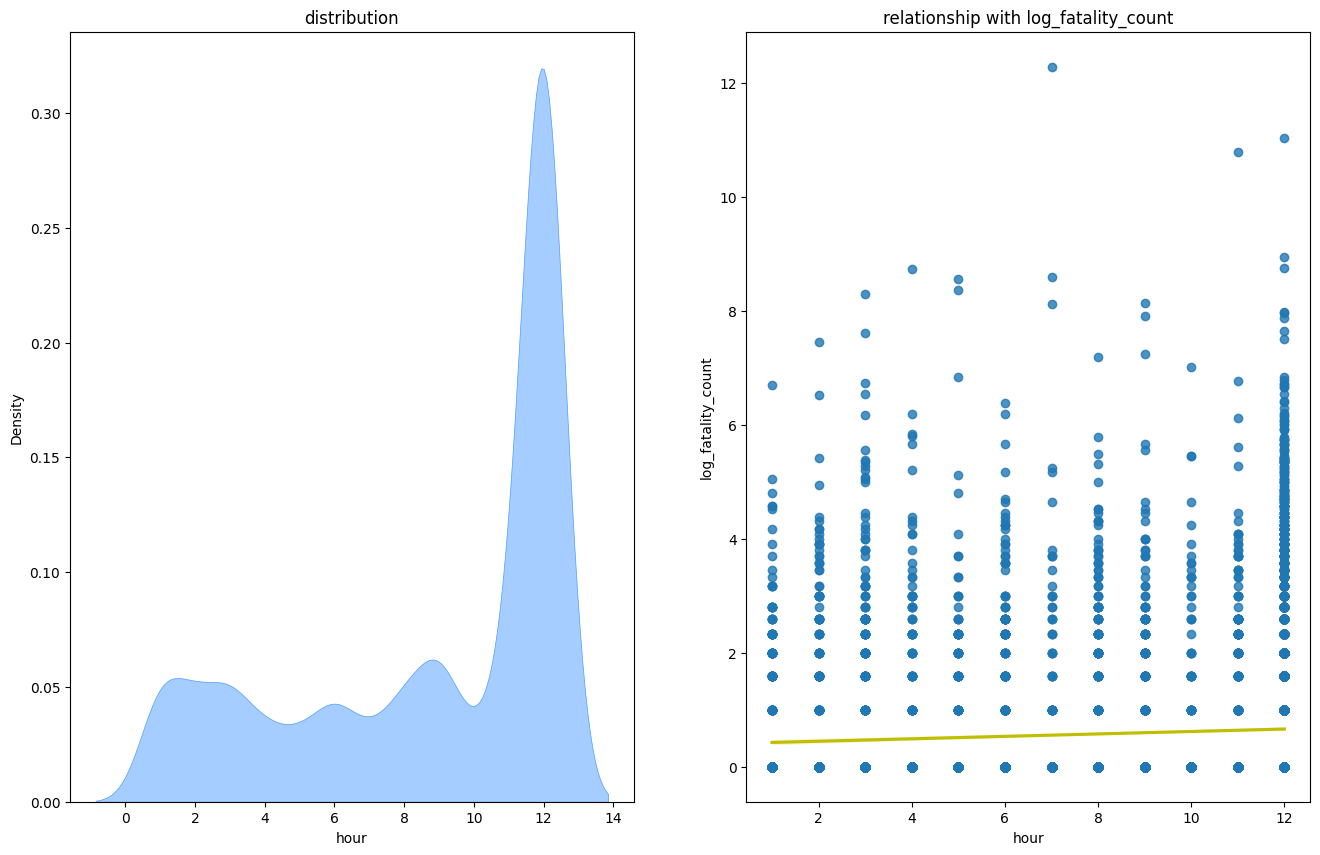

In [1234]:
get_dist_numeric('hour', full_data)

None of the time variables seem to provide a lot of information on casualty, which is rather surprising.

<div style="font-size: 20px"><b>Categorical Variables Distributions</b></div> 

<div style="border: 1px solid lightgrey; width: 80%"></div>

In [1235]:
categorical_columns = ['event_source', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting']

In [1236]:
def get_categorical_column_dist(col, full_data):
    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    fig.set_size_inches(12, 12)
    ax1 = axes[0]
    df_sort = full_data.groupby(col)['log_fatality_count'].mean().sort_values(ascending=False).index
    sns.barplot(x='log_fatality_count', y=col, data=full_data, color='#4D9DFF', order=df_sort,
                estimator=np.mean, errorbar=None, err_kws={'linewidth': 0}, ax=ax1)
    for p in ax1.patches:
        ax1.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width() / 2. + 0.2, p.get_y() + p.get_height() + 0.5),
                    ha='center', va='center', xytext=(0, 20), textcoords='offset points', fontsize=10, color='black')
    ax1.set_title(f'Mean log_fatality_count by {col}')
    ax1.set_xlabel('log_fatality_count')
    ax1.set_ylabel('')
    sns.despine(left=True, bottom=True, ax=ax1)
    
    ax2 = axes[1]
    sns.violinplot(x='log_fatality_count', y=col, data=full_data, color='#4D9DFF', order=df_sort, ax=ax2)
    ax2.set_title(f'Distribution of log_fatality_count by {col}')
    ax2.set_ylabel("")
    sns.despine(left=True, bottom=True, ax=ax2)
    plt.tight_layout()
    plt.show()

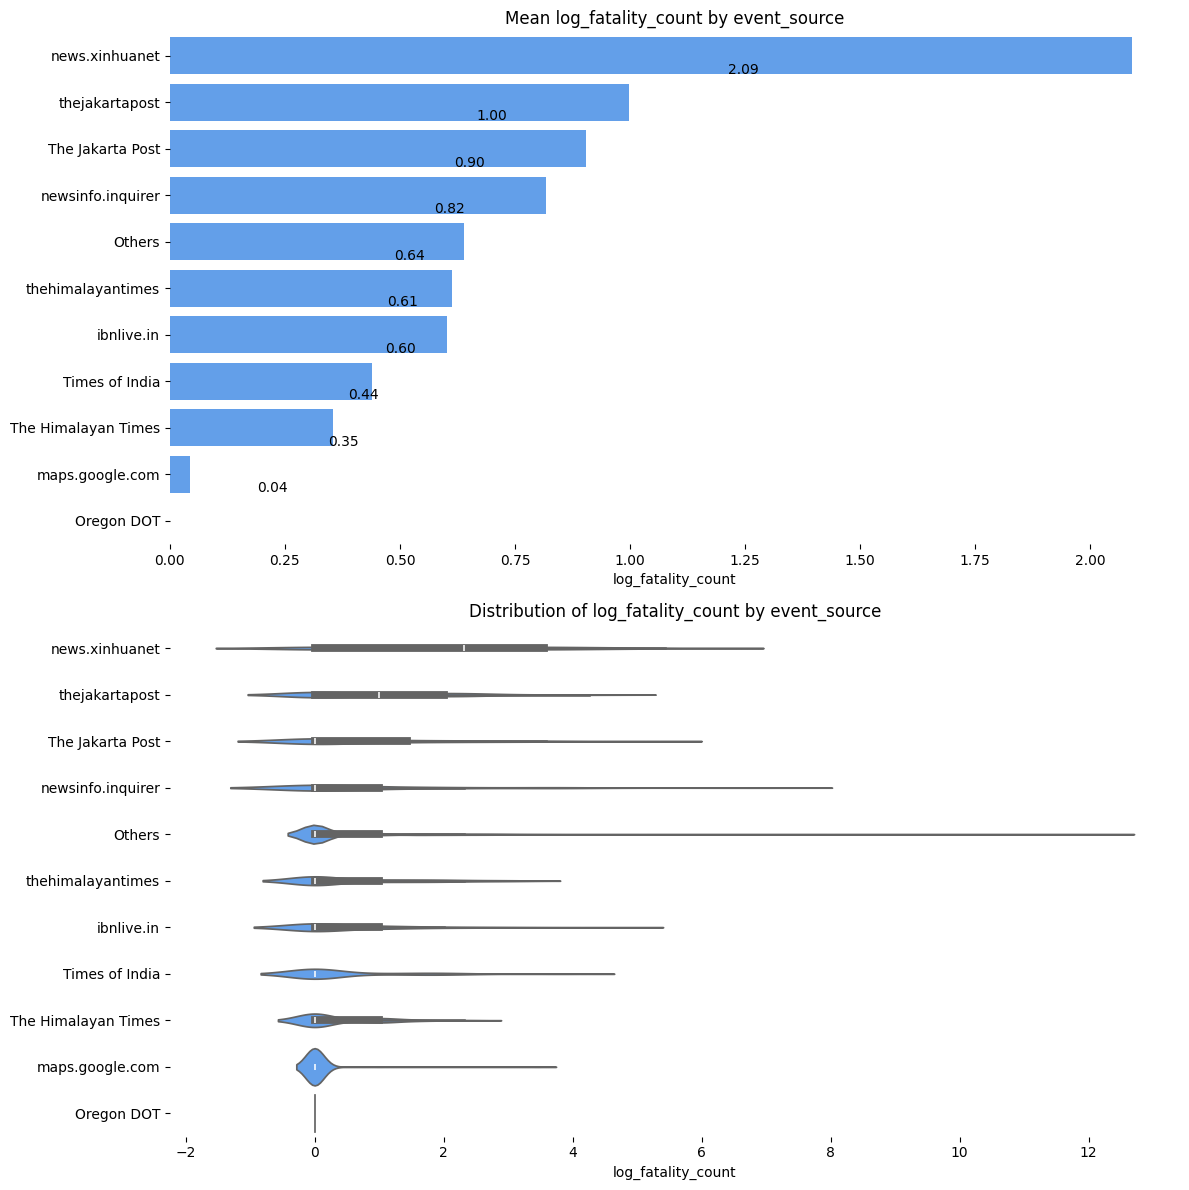

In [1237]:
get_categorical_column_dist('event_source', full_data)

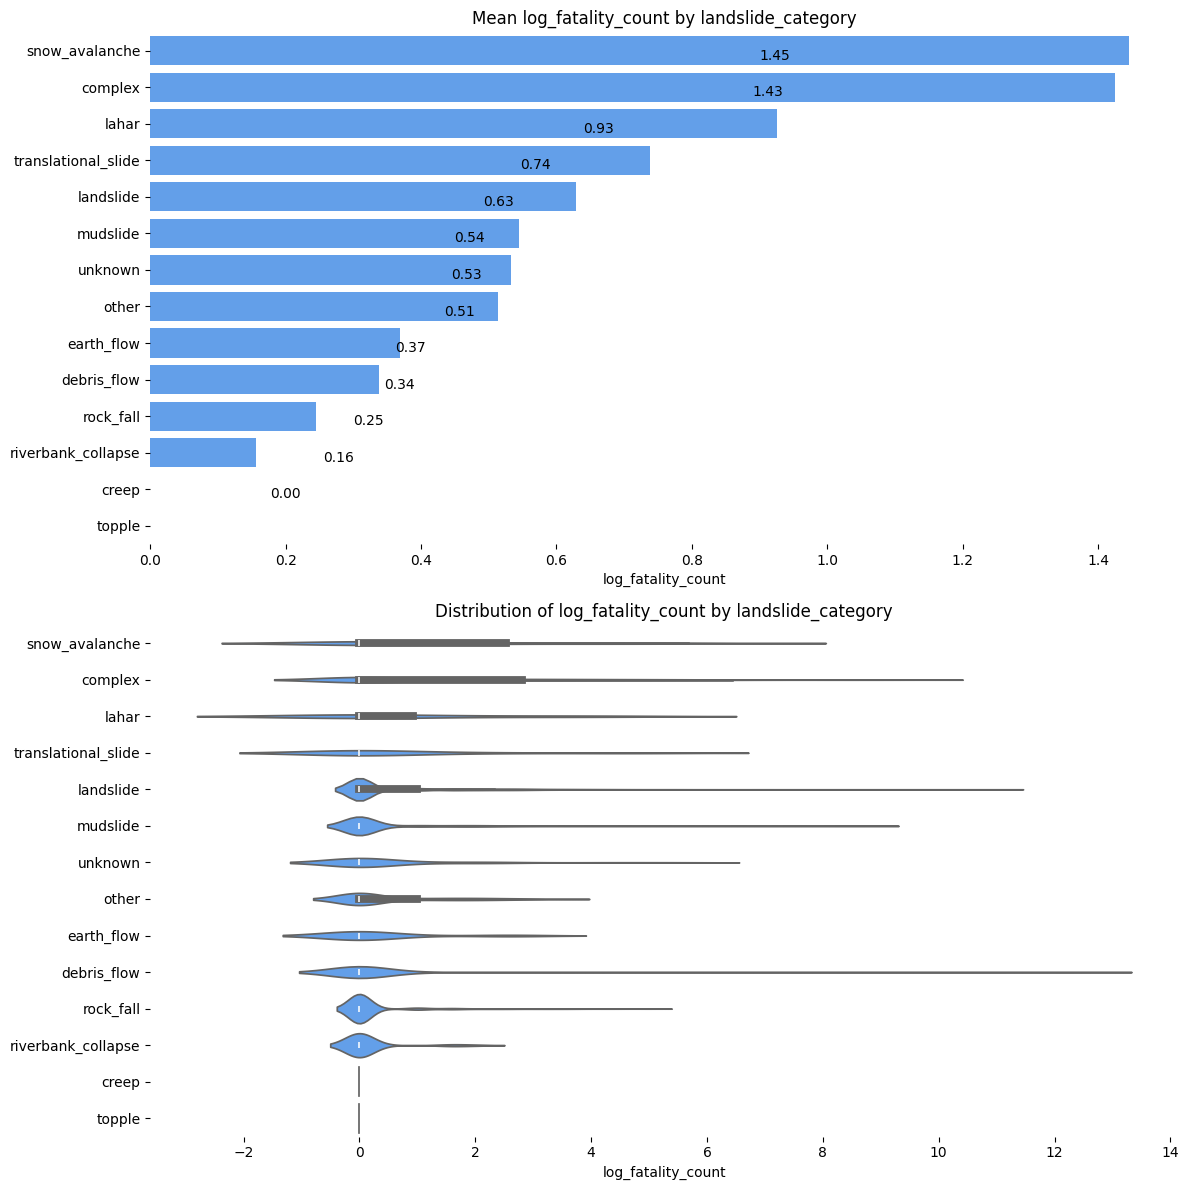

In [1238]:
get_categorical_column_dist('landslide_category', full_data)

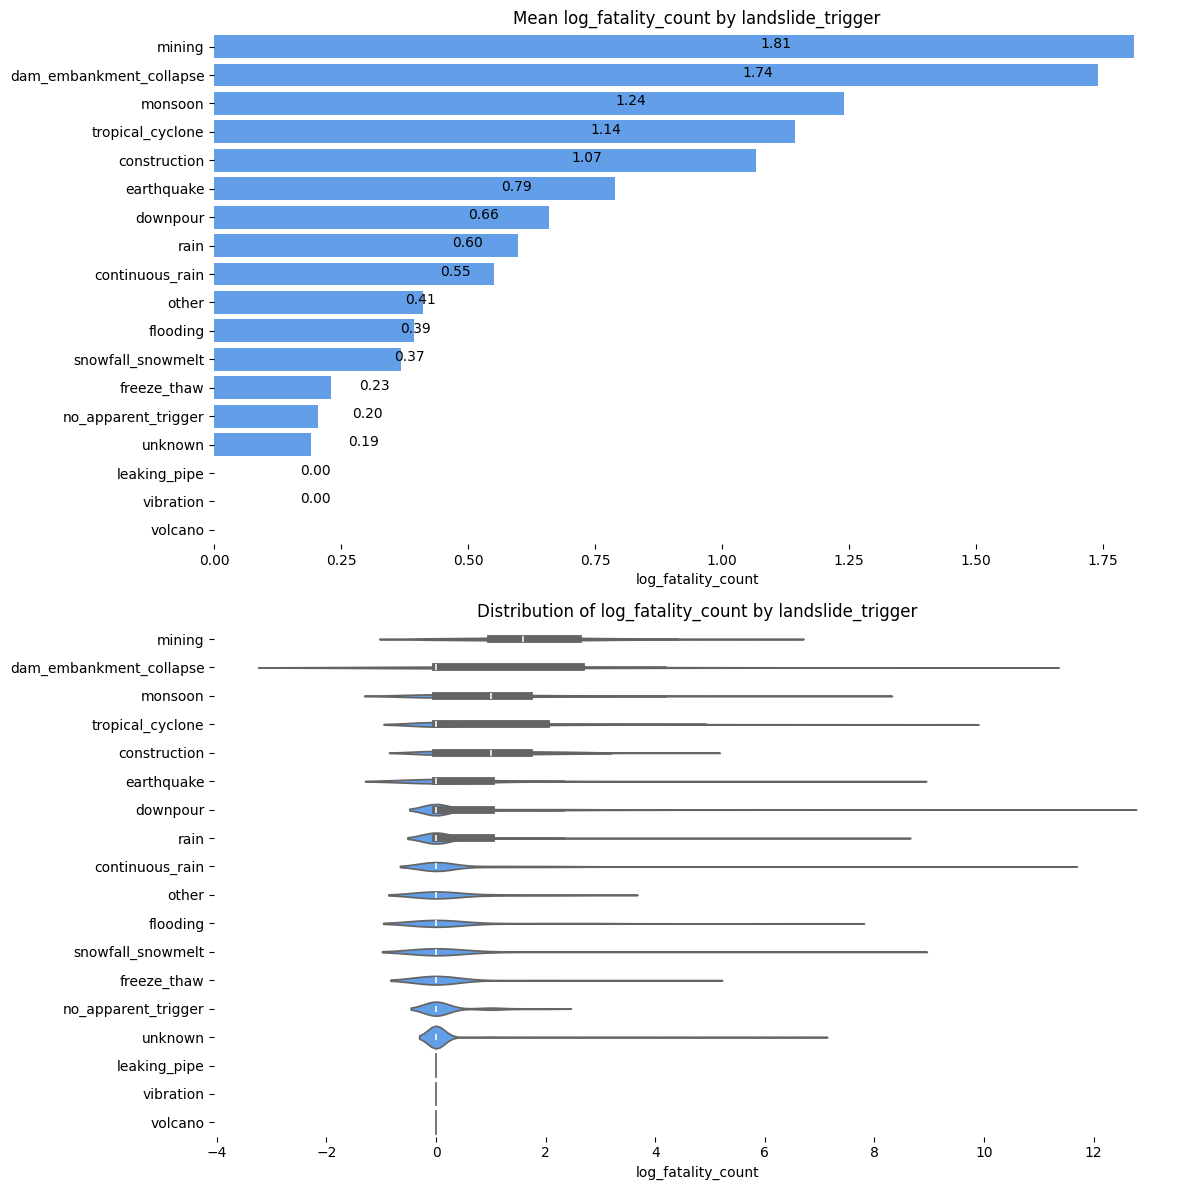

In [1239]:
get_categorical_column_dist('landslide_trigger', full_data)

It is not clear from the source of the Global Landslide Catelog how landslide_size is determined. It is based on factors like infrastructure damage and area of affected region, then it is worth to keep it as a predictor.

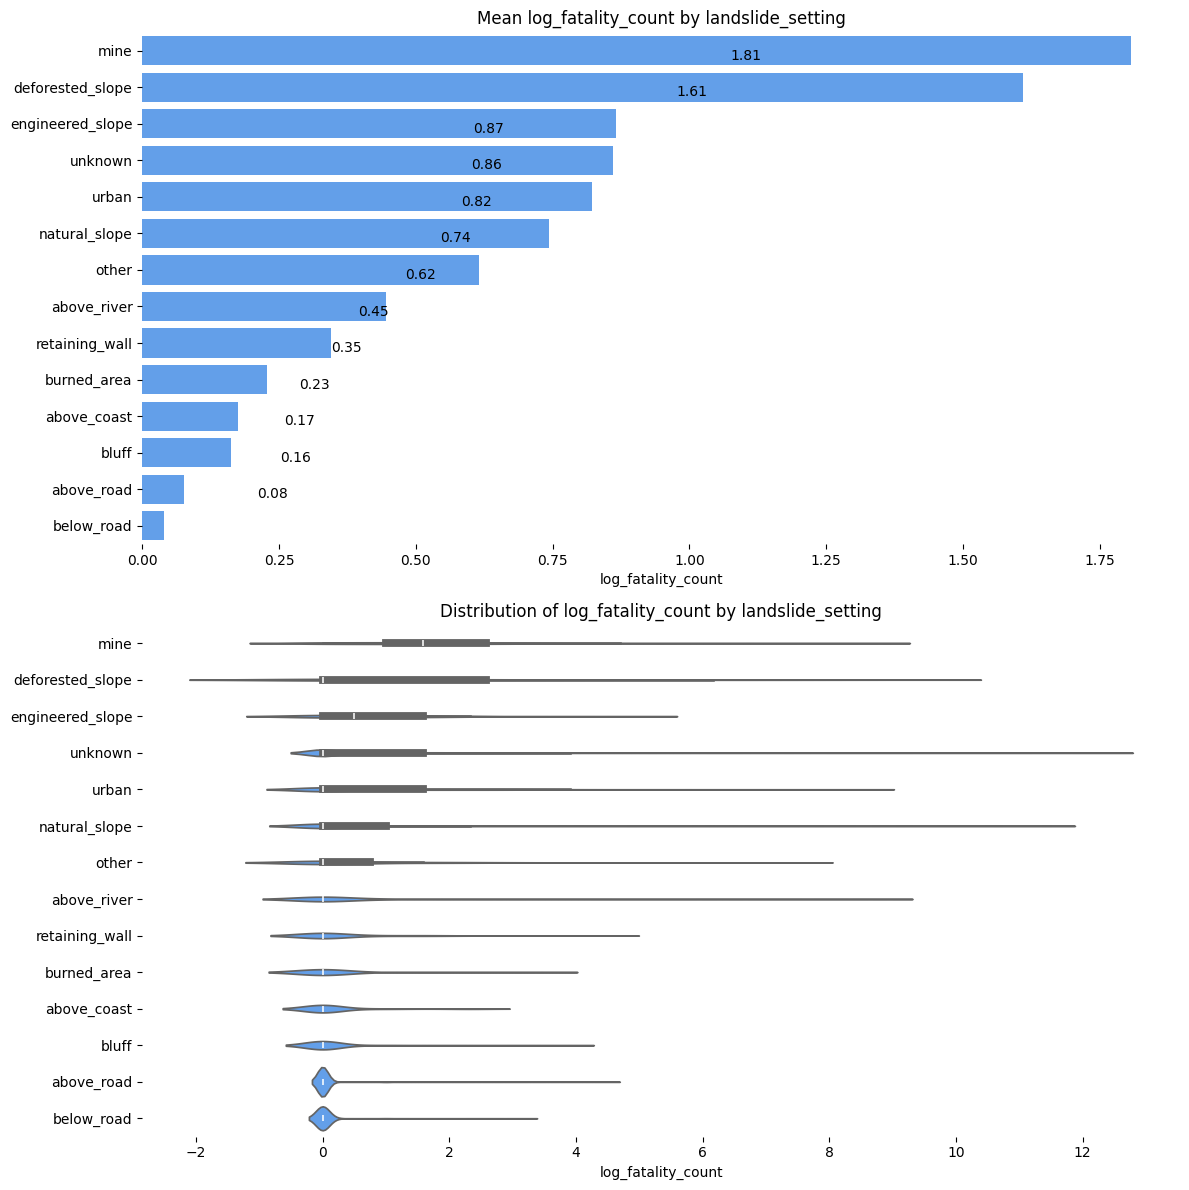

In [1240]:
get_categorical_column_dist('landslide_setting', full_data)

Among the different settings, mine and deforested_slope are associated with much higher fatality_count


<div style="border: 1px solid lightgrey; width: 90%"></div>

<div style="font-size: 30px"><b>Models</b></div>

In [1257]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, make_scorer

In [1242]:
X = full_data.drop(['log_fatality_count'], axis=1)
y = full_data['log_fatality_count']

In [1271]:
X.describe()

,year,hour,month,landslide_size,injury_count,longitude,latitude,gdp
count,9640.000000,9640.000000,9640.000000,9640.000000,9640.000000,9640.000000,9640.000000,9.640000e+03
mean,2013.046058,8.848133,6.295954,0.731017,0.750702,-1.191145,26.123176,6.767475e+12
std,2.891573,3.860866,3.382713,0.629984,6.306452,101.464948,20.563951,6.816685e+12
min,1988.000000,1.000000,1.000000,0.000000,0.000000,-179.980766,-46.774800,4.213741e+08
25%,2011.000000,6.000000,3.000000,0.000000,0.000000,-112.226950,14.478125,3.380661e+11
50%,2013.000000,11.000000,6.000000,1.000000,0.750702,6.830850,30.996997,6.087192e+12
75%,2015.000000,12.000000,9.000000,1.000000,0.750702,92.854355,41.599716,1.504897e+13
max,2017.000000,12.000000,12.000000,4.000000,374.000000,179.991364,72.627500,1.880491e+13


<div style="font-size: 15px"><b>Convert categorical variables to indicator variables</b></div>

In [1243]:
categorical_non_ord_variables = ['event_source', 'landslide_category', 'landslide_trigger', 'landslide_setting']
X = pd.get_dummies(X, columns=categorical_non_ord_variables, drop_first=True)

In [1244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
for col in numeric_columns:
    X_train[col] = (X_train[col] - X_train[col].mean()) / X_train.std()

<div style="font-size: 25px"><b>Linear Models</b></div>

In [1246]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

<div style="font-size: 20px"><b>Linear Regression</b></div>
We will start with the linear regression model


<div style="border: 1px solid lightgrey; width: 90%"></div>

In [1247]:
linear_model = LinearRegression()

In [1248]:
linear_model.fit(X = X_lm_train,y = y_train)

LinearRegression()

In [1249]:
y_train_preds = linear_model.predict(X_lm_train)

In [1250]:
print('training R^2', r2_score(y_train, y_train_preds))

training R^2 0.31479574014352185


In [1251]:
y_test_preds = linear_model.predict(X_test)

In [1252]:
print('test R^2', r2_score(y_test, y_test_preds))

test R^2 0.24378587774757465


We have seen that the distribution of fatality_count has 2 modes (local maxima) and is right skewed. Not surprisingly, linear regression does not give a good fit. We do notice a drop in R squared for the test set, so we will try regularized linear models, ridge regression and Lasso.

<div style="font-size: 20px"><b>Ridge Regression</b></div>

In [1270]:
ridge_model = Ridge(normalize=True)
ridge_params = {'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}

TypeError: Ridge.__init__() got an unexpected keyword argument 'normalize'

In [1268]:
r2_scorer = make_scorer(r2_score, greater_is_better=True)

grid_ridge_models = GridSearchCV(ridge_model,
                          ridge_params,
                          scoring = r2_scorer,
                          cv=5)

In [1269]:
grid_ridge_models.fit(X_train, y_train)

/Users/yzhang/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.68871e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/yzhang/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.50478e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/yzhang/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.53781e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/yzhang/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.59519e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [10, 30, 100, 200, 300, 400, 800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(r2_score, response_method='predict'))